## Predicting Total Playtime from Player Characteristics in Minecraft


## Introduction

The dataset for this project comes from a Minecraft research server operated by the Pacific Laboratory for Artificial Intelligence (PLAI), a computer science research group at UBC led by Professor Frank Wood. PLAI studies generative modeling, programming, and AI. Their PLAICraft initiative collects large-scale behavioral data from real players navigating a shared virtual server in Minecraft. Every player who joins the server contributes to a growing dataset that supports research on how humans play video games and how they interact within this specific environment.

Game analytics plays a central role in understanding how people interact with digital environments. By examining patterns in player activity such as a player's session frequency, duration, and engagement levels, we can further research about human behavior and AI to better predict resource allocation and user engagement. Since this server is an active research project rather than a commercial game, understanding player behavior and activity levels is essential so they can plan server hardware, storage, and data-processing resources effectively. Specifically, being able to identify which players engage the most with the game can support targeted recruitment and improved strategies for maintaining long-term engagement



This leads us to the central question of this project:

**Can player characteristics predict the total number of hours a player spends on the server?**

We will use **experience**, **gender**, and **Age** as explanatory variables to predict the response variable **played_hours**. These predictors were chosen because they are the only available player characteristics that could reasonably influence engagement patterns and help explain differences in total time spent on the server.

This project uses the dataset from the Minecraft research server: `players.csv`.

The **players** file contains 196 rows and 7 variables describing each participant, and the **sessions** file contains 1,535 rows documenting every recorded session.  
Below is a concise summary of all variables.


### Variables in `players.csv`

+ `experience`, Character, experience level of each player, which includes `Beginner`, `Amateur`, `Regular`, `Pro`, and `Veteran`.
+ `subscribe`, Logical, wheather the player subscribe the game newsletter
+ `hashedEmail`, Character, recorded email addresses of players
+ `played_hours`, Double, total number of hours the player has spent playing games
+ `name`, Character, name of player
+ `gender`, Character, gender of player, eg. `Female`, `Male`, `Non-binary`
+ `Age`, Double, age of player


### Variables in `sessions.csv`

+ `hashedEmail`, Character, recorded email addresses of players
+ `start_time`, Character, local time when the session began
+ `end_time`, Character, local time when the session ended
+ `original_start_time`, Double, Unix-style timestamp when the session began
+ `original_end_time`, Double, Unix-style timestamp when the session ended

## Issues and Notes

- Some missing values in both datasets  
- Large variation in lifetime hours and number of sessions per player  
- Self-reported values may include bias  
- Session logs may be incomplete or uneven  
- Voluntary participation may introduce selection bias  

By joining these tables on **hashedEmail**, we can link player characteristics to their session histories and total hours played, allowing us to build and evaluate predictive models.


## Data Loading and Wrangling


In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_dataset <- read.csv("https://drive.google.com/uc?export=download&id=1uLgyqhTWde6lDwTPmpDHTHndMKkr0eGn")
head(players_dataset)
tail(players_dataset)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
191,Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
192,Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
193,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
194,Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
195,Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
196,Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
players_cleaned <- players_dataset |>
    select(Age, gender, experience, played_hours) |>
    mutate(gender = case_match
            (gender, "Male" ~ "Male", 
             "Female" ~ "Female", 
             .default = "Other")) |>
    mutate(experience = as_factor(experience), gender = as_factor(gender))
head(players_cleaned)
tail(players_cleaned)

,Age,gender,experience,played_hours
,<int>,<fct>,<fct>,<dbl>
1,9,Male,Pro,30.3
2,17,Male,Veteran,3.8
3,17,Male,Veteran,0.0
4,21,Female,Amateur,0.7
5,21,Male,Regular,0.1
6,17,Female,Amateur,0.0


,Age,gender,experience,played_hours
,<int>,<fct>,<fct>,<dbl>
191,20,Male,Amateur,0.0
192,17,Female,Amateur,0.0
193,22,Male,Veteran,0.3
194,57,Other,Amateur,0.0
195,17,Male,Amateur,2.3
196,NA,Other,Pro,0.2


Loading in the dataset from a URL and then tidying the data by selecting the relavent columns - Age, gender, experience, and played_hours. We mutated the gender column so that all genders not listed as "Female" or "Male" are "Other," in order to succinctly visualize the data and infer from it. We also changed the data type of Experience and Gender to factors to also help with the visualization.

In [4]:
players_experience <- players_cleaned |> 
  group_by(experience) |> 
  summarise(mean_hours = mean(played_hours), 
            median_hours = median(played_hours),
            count = n())
players_experience

experience,mean_hours,median_hours,count
<fct>,<dbl>,<dbl>,<int>
Pro,2.6000000,0.3,14
Veteran,0.6479167,0.1,48
Amateur,6.0174603,0.1,63
Regular,18.2083333,0.1,36
Beginner,1.2485714,0.1,35


In [5]:
players_gender <- players_cleaned|>
    group_by(gender) |>
    summarise(mean_hours = mean(played_hours), 
            median_hours = median(played_hours),
            count = n())
players_gender

gender,mean_hours,median_hours,count
<fct>,<dbl>,<dbl>,<int>
Male,4.127419,0.1,124
Female,10.635135,0.1,37
Other,6.871429,0.0,35


In [6]:
players_summarized <- players_cleaned |>
    summarize(Mean_age = mean(Age, na.rm = TRUE))
players_summarized

players_age <- players_cleaned|>
   group_by(Age) |>
   summarise(mean_hours = mean(played_hours), 
            median_hours = median(played_hours),
            count = n())
players_age

Mean_age
<dbl>
21.13918


Age,mean_hours,median_hours,count
<int>,<dbl>,<dbl>,<int>
9,30.3000000,30.30,1
10,3.6000000,3.60,1
11,2.9000000,2.90,1
12,0.5000000,0.50,1
14,8.7000000,8.70,2
15,0.1000000,0.10,2
16,50.0333333,0.10,3
17,4.8863014,0.00,73
18,0.2285714,0.10,7


Calculating summary statistics(mean and median) of played hours for all variables we will use in modeling. Also computed the mean on gender of all players in the dataset, excluding NA values, which is 21.139 years.

In [7]:
summary(players_cleaned$played_hours)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.100   5.846   0.600 223.100 

## Data Visualizations


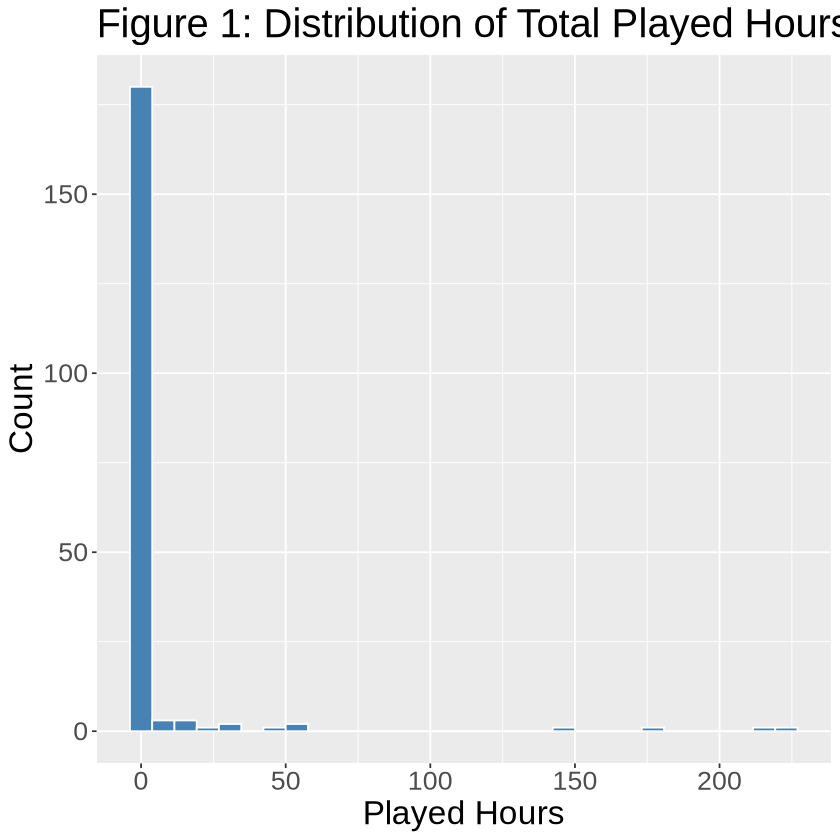

In [8]:
ggplot(players_cleaned, aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  labs(title = "Figure 1: Distribution of Total Played Hours",
       x = "Played Hours",
       y = "Count") +
  theme(text= element_text(size = 20))

The graph indicates the distribution of total played hours, showing skewness of response variable. (skew to the right)

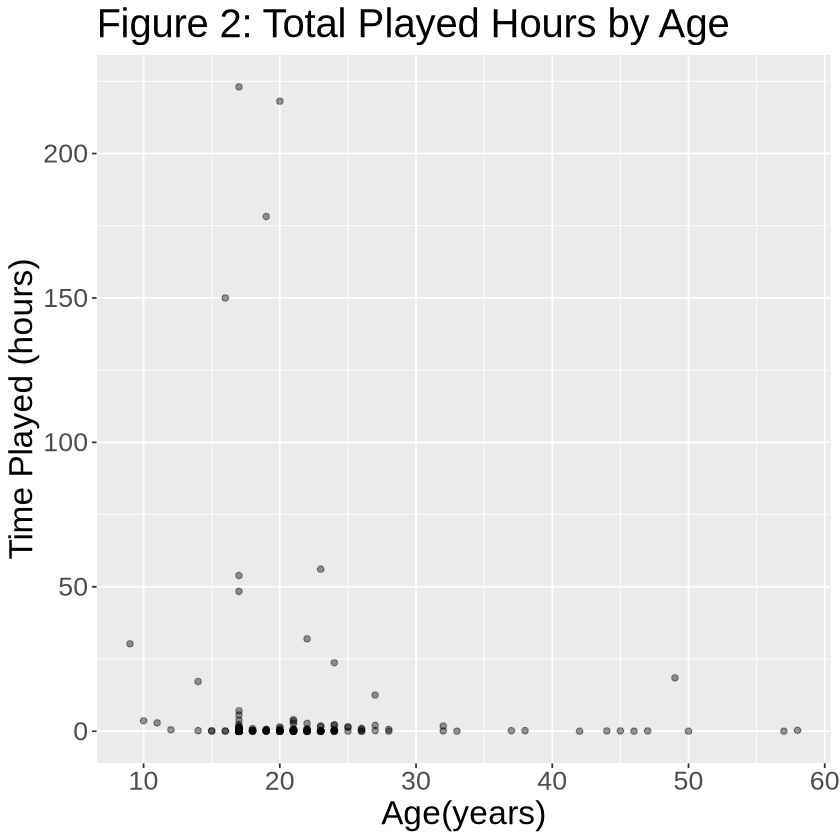

In [19]:
age_plot <- ggplot(players_cleaned, aes(x = Age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    xlab("Age(years)") +
    ylab("Time Played (hours)") +
    ggtitle("Figure 2: Total Played Hours by Age") +
    theme(text= element_text(size = 20))
age_plot

This scatterplot demonstrates the relationship between age and time played, and demonstrates that the age ranges from ~9 to ~57 years, and that the age with the most hours played is around 15-20. The opacity of the points also shows how there are many data entries with 0 hours.

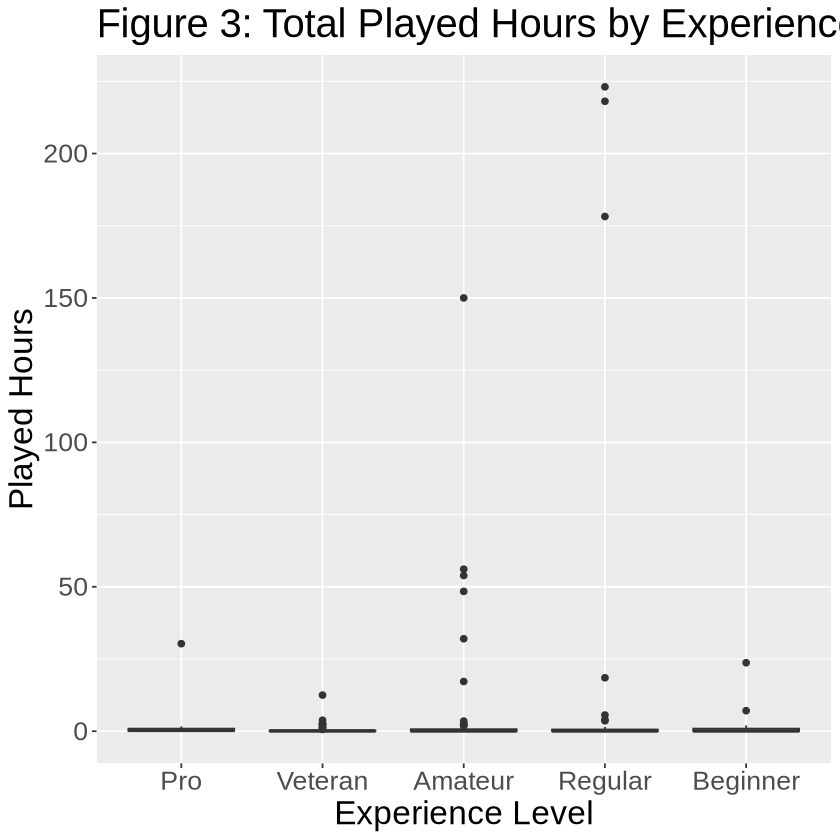

In [20]:
experience_plot <- ggplot(players_cleaned, aes(x = experience, y = played_hours)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Figure 3: Total Played Hours by Experience Level",
       x = "Experience Level",
       y = "Played Hours") +
  theme(text= element_text(size = 20))
experience_plot

This plot visualizes the relationship between experience and time played, demonstrating that the most played hours came from players in the Regular and Amateur experience classes, with significantly less from the Pro, Veteran, and Beginner levels. This could be because there are many more players in the amateur and regular groups therefore contributing more. 

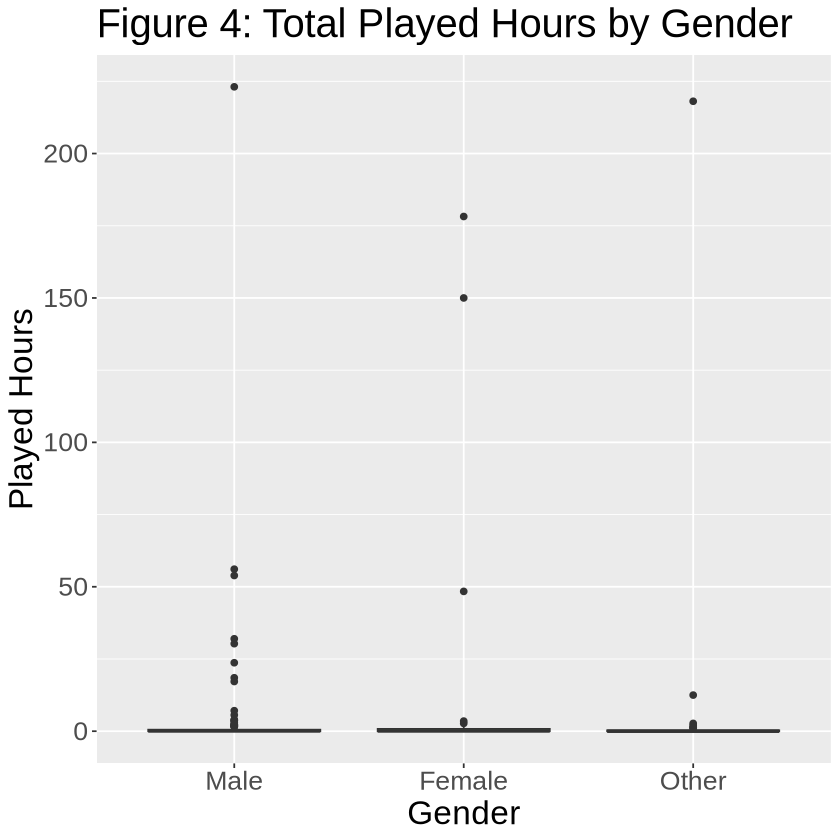

In [21]:
gender_plot <- ggplot(players_cleaned, aes(x = gender, y = played_hours)) +
  geom_boxplot(fill = "lightgreen") +
  labs(title = "Figure 4: Total Played Hours by Gender",
       x = "Gender",
       y = "Played Hours") +
  theme(text= element_text(size = 20))
gender_plot

This visualization demonstrates the relationship between gender and time played, showing that the amount of time played by each gender is very spread out, with low values of 0 and high values of 175-225 hours. It shows that the amount of time played by the Male gender is higher than Female and Other. Again, this could be because there are more males who contributed data than the other genders. 

In [12]:
gender_matrix <- model.matrix(~ gender - 1, data = players_cleaned)
experience_matrix <- model.matrix(~ experience - 1, data = players_cleaned)

players_cleaned <- players_cleaned |>
  mutate(Age = ifelse(is.na(Age), median(Age, na.rm = TRUE), Age))

players_ready <- players_cleaned |>
  select(Age, played_hours, gender, experience) |> 
  bind_cols(as_tibble(gender_matrix)) |>
  bind_cols(as_tibble(experience_matrix)) |>
  select(-gender, -experience)

head(players_ready)

,Age,played_hours,genderMale,genderFemale,genderOther,experiencePro,experienceVeteran,experienceAmateur,experienceRegular,experienceBeginner
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9,30.3,1,0,0,1,0,0,0,0
2,17,3.8,1,0,0,0,1,0,0,0
3,17,0.0,1,0,0,0,1,0,0,0
4,21,0.7,0,1,0,0,0,1,0,0
5,21,0.1,1,0,0,0,0,0,1,0
6,17,0.0,0,1,0,0,0,1,0,0


This step is neccessary since KNN regression works based on distance, it is not able to use text categories. So we have to create dummy variables for gender and experience.

## Modeling & Results

To investigate whether player characteristics can predict the total number of hours a player spends on the Minecraft research server, we conducted a full data analysis workflow consisting of loading, cleaning, exploring, and modeling the dataset. We first selected the relevant variables—Age, gender, and experience—from the player dataset and cleaned the data by recoding categorical values and handling missing entries. 

As the response variable, `played_hours`, is numerical, the problem should be regression. 
To determine whether player characteristics can predict the total number of hours a player spends on the Minecraft research server, we use **k-Nearest Neighbors (kNN) Regression** model.

Since kNN relies on distance calculations, all predictors must be numerical and on comparable scales. Gender and experience must therefore be dummy-encoded, and all predictors must be centered and scaled before training the model.

Next, we performed exploratory data analysis, including summary statistics and visualizations, to understand the distribution of played hours and its relationship with the predictors. After this, the cleaned dataset was split into training (75%) and testing (25%) sets, and we trained a kNN regression model to predict played_hours. A **5-fold cross-validation** procedure was used to tune the number of neighbors (K), and we evaluate the model’s performance by using the Root Mean Squared Prediction Error (RMSPE). The final model and tuning results are presented along with visualizations.

In [13]:
set.seed(1234)
players_split <- initial_split(players_ready, prop = 0.75)
players_train <- training(players_split)
players_test  <- testing(players_split)

In [14]:
set.seed(1234)
players_recipe <- recipe(played_hours ~., data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

We use 5-fold cross-validation to tune k.

In [15]:
set.seed(1234)
players_vfold <- vfold_cv(players_train, v = 5)

players_k_grid <- tibble(neighbors = seq(from = 1, to = 30, by = 2))

In [16]:
set.seed(1234)
players_wf <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_result <- players_wf |>
  tune_grid(resamples = players_vfold, grid = players_k_grid) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  arrange(mean)
players_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,24.25733,5,5.633847,Preprocessor1_Model08
13,rmse,standard,24.30392,5,5.534480,Preprocessor1_Model07
11,rmse,standard,24.33531,5,5.464517,Preprocessor1_Model06
17,rmse,standard,24.46545,5,5.658356,Preprocessor1_Model09
7,rmse,standard,24.73167,5,5.507758,Preprocessor1_Model04
19,rmse,standard,24.85606,5,5.568902,Preprocessor1_Model10
5,rmse,standard,24.91841,5,5.493736,Preprocessor1_Model03
27,rmse,standard,24.93565,5,5.637433,Preprocessor1_Model14
21,rmse,standard,24.95277,5,5.522102,Preprocessor1_Model11


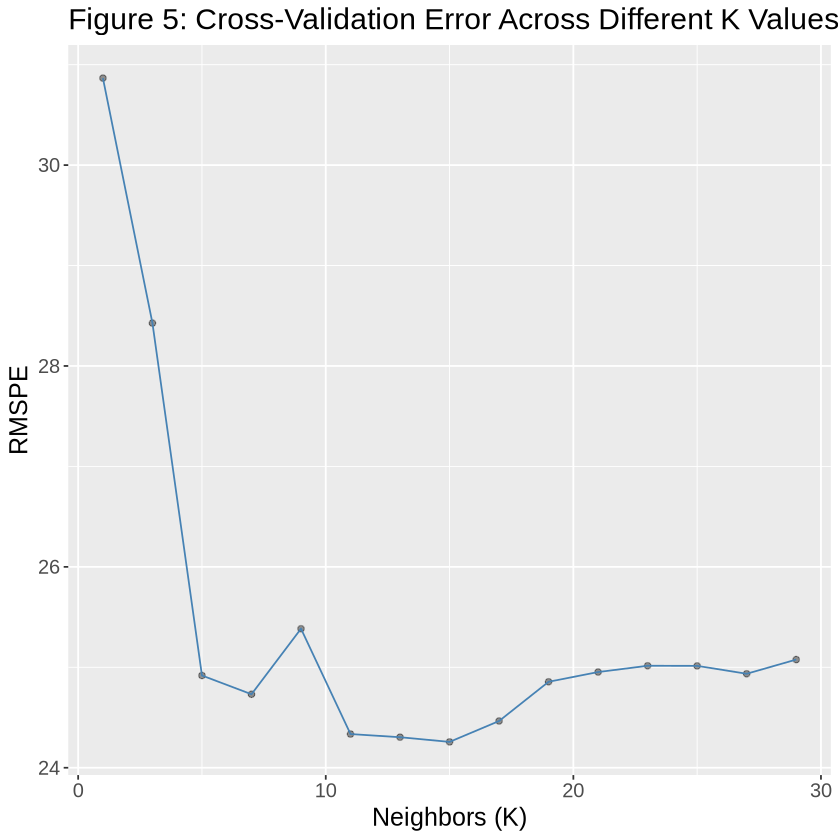

In [37]:
ggplot(players_result, aes(x = neighbors, y = mean)) +
   geom_point(alpha = 0.4) +
   geom_line(color = "steelblue") +
   labs(title = "Figure 5: Cross-Validation Error Across Different K Values",
    x = "Neighbors (K)",
    y = "RMSPE") +
   theme(text = element_text(size = 15))

Figure 5: Cross-validation tuning plot for the kNN regression model. We choose K that minimizes prediction error.

In [41]:
best_k <- filter(players_result, mean == min(mean))

best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,24.25733,5,5.633847,Preprocessor1_Model08


In [42]:
kmin <- best_k |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_preds <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) 
 

players_mets <- players_preds |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
players_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,33.56711


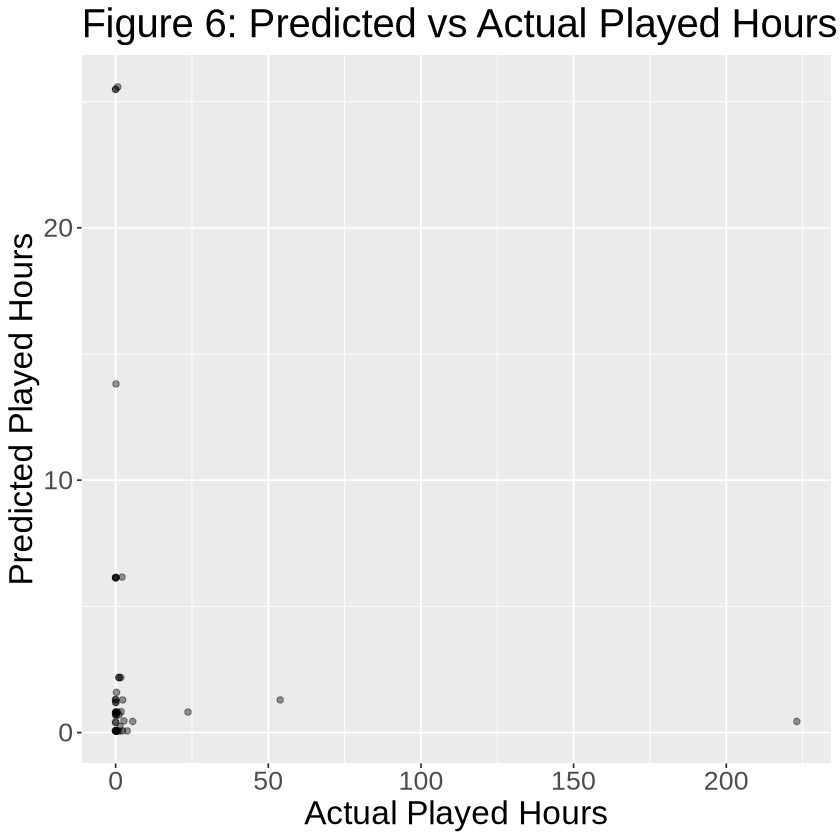

In [43]:
ggplot(players_preds, aes(x = played_hours, y = .pred)) +
  geom_point(alpha = 0.4) +
  labs(title = "Figure 6: Predicted vs Actual Played Hours",
       x = "Actual Played Hours",
       y = "Predicted Played Hours") +
  theme(text = element_text(size = 20))